In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
# Feature method selection
mode_select = "ORB"     # SIFT, ORB, GF2T
num_features = 1000

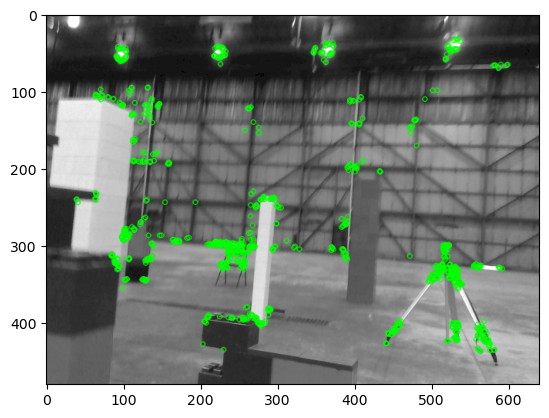

(<matplotlib.image.AxesImage at 0x7f462d70e3a0>, None)

In [3]:
img0 = cv.imread('DEPTH_IMAGE0.PNG', cv.IMREAD_GRAYSCALE)
img1 = cv.imread('DEPTH_IMAGE1.PNG', cv.IMREAD_GRAYSCALE)


if mode_select == "SIFT":
    sift = cv.SIFT_create(nfeatures=num_features)
    kp0, des0 = sift.detectAndCompute(img0,None)
    kp1, des1 = sift.detectAndCompute(img1,None)
elif mode_select == "SURF":
    surf = cv.xfeatures2d.SURF_create(num_features)
    kp0, des0 = surf.detectAndCompute(img0,None)
    kp1, des1 = surf.detectAndCompute(img1,None)
elif mode_select == "ORB":
    orb = cv.ORB_create(nfeatures=num_features)
    kp0, des0 = orb.detectAndCompute(img0,None)
    kp1, des1 = orb.detectAndCompute(img1,None)
elif mode_select == "GF2T":
    corners = cv.goodFeaturesToTrack(img0,num_features,0.01,10)
    corners = np.int0(corners)
else:
    print("Invalid choice of feature method")


# draw only keypoints location,not size and orientation
img2 = cv.drawKeypoints(img0, kp0, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

In [4]:
%%timeit
# For timing different algorithms

if mode_select == "SIFT":
    sift = cv.SIFT_create(nfeatures=num_features)
    kp0, des0 = sift.detectAndCompute(img0,None)
    kp1, des1 = sift.detectAndCompute(img1,None)
elif mode_select == "SURF":
    surf = cv.xfeatures2d.SURF_create(num_features)
    kp0, des0 = surf.detectAndCompute(img0,None)
    kp1, des1 = surf.detectAndCompute(img1,None)
elif mode_select == "ORB":
    orb = cv.ORB_create(nfeatures=num_features)
    kp0, des0 = orb.detectAndCompute(img0,None)
    kp1, des1 = orb.detectAndCompute(img1,None)
elif mode_select == "GF2T":
    corners = cv.goodFeaturesToTrack(img0,num_features,0.01,10)
    corners = np.int0(corners)
else:
    print("Invalid choice of feature method")

15 ms ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


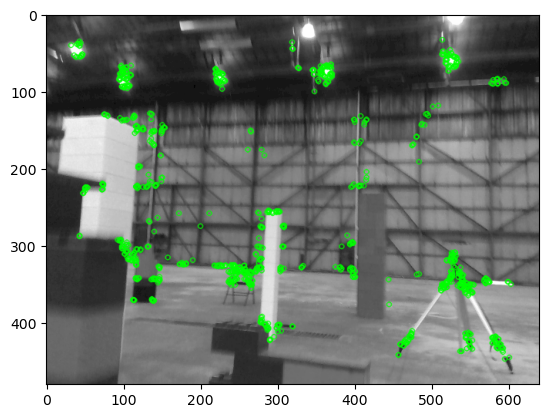

(<matplotlib.image.AxesImage at 0x7f462858d370>, None)

In [5]:
img3 = cv.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
plt.imshow(img3), plt.show()

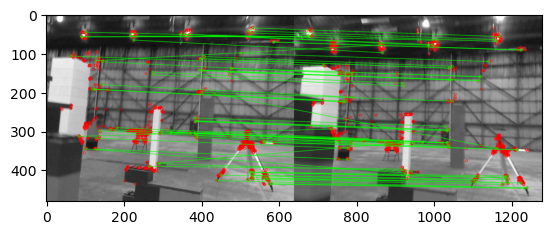

(<matplotlib.image.AxesImage at 0x7f462853a5e0>, None)

In [6]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(np.float32(des0),np.float32(des1),k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img0,kp0,img1,kp1,matches,None,**draw_params)
plt.imshow(img3,),plt.show()

In [11]:
count = 0
good_m = []
for i, match in enumerate(matchesMask):
    if match[0] == 1:
        good_m.append(matches[i])
        count += 1
        
print("Number of filtered matches: ", count)

# Loop through all good points and store their x and y pixel location   
# Initialize lists
list_kp0 = []
list_kp1 = []

# For each match...
for lcv, mat in enumerate(good_m):

    # Get the matching keypoints for each of the images
    img0_idx = mat[0].queryIdx
    img1_idx = mat[0].trainIdx

    # x - columns
    # y - rows
    # Get the coordinates
    (x0, y0) = kp0[img0_idx].pt
    (x1, y1) = kp1[img1_idx].pt

    # Append to each list
    list_kp0.append((x0, y0))
    list_kp1.append((x1, y1))

print("Pixel locations for \"good\" matches for both images:")
print("list_kp0", list_kp0)
print("list_kp1", list_kp1)

Number of filtered matches:  69
Pixel locations for "good" matches for both images:
list_kp0 [(576.0, 436.0), (582.0, 435.0), (522.0, 40.0), (103.0, 44.0), (567.0, 422.0), (535.0, 405.0), (288.0, 382.0), (102.0, 345.0), (534.0, 33.0), (442.0, 427.0), (389.0, 311.0), (533.0, 419.0), (520.800048828125, 423.6000061035156), (266.4000244140625, 390.0000305175781), (388.8000183105469, 272.4000244140625), (451.20001220703125, 412.8000183105469), (129.60000610351562, 345.6000061035156), (586.800048828125, 69.60000610351562), (165.60000610351562, 295.20001220703125), (347.0400085449219, 48.96000289916992), (358.5600280761719, 48.96000289916992), (92.16000366210938, 56.160003662109375), (561.6000366210938, 326.8800048828125), (525.6000366210938, 46.08000183105469), (527.0400390625, 404.6400146484375), (126.72000122070312, 191.52000427246094), (587.52001953125, 69.12000274658203), (397.44000244140625, 142.5600128173828), (91.5840072631836, 55.29600524902344), (217.72802734375, 53.5680046081543), 

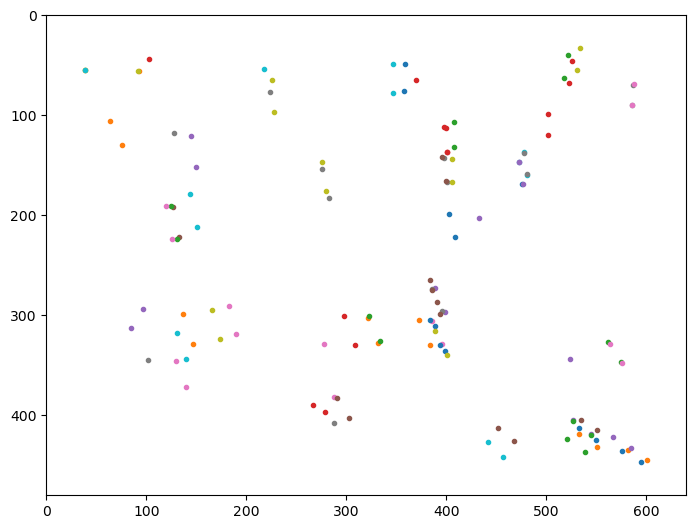

In [30]:
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])

for lcv in range(len(good_m)):
    a1.plot([list_kp0[lcv][0], list_kp1[lcv][0]], [list_kp0[lcv][1], list_kp1[lcv][1]], '.')

a1.set_ylim(0,img0.shape[0])
a1.set_xlim(0,img0.shape[1])
plt.gca().invert_yaxis()
plt.show()

In [36]:
# Pixel to 3D point

# self.object_width = rospy.get_param('object_width', 0.06)
object_width = 

# K = np.reshape(msg.K, (3, 3))
K = [607, 0, 319, 0, 608, 237, 0, 0, 1]

K = np.reshape(K, (3, 3))
f_x = K[0, 0]
f_y = K[1, 1]
c_x = K[0, 2]
c_y = K[1, 2]


# z = (f_x*self.object_width)/msg.roi.width
# z = from depth
x = ((msg.roi.x_offset + msg.roi.width/2 - c_x)*z)/f_x
y = ((msg.roi.y_offset + msg.roi.height/2 - c_y)*z)/f_y
p_rel = np.array([x, y, z])

array([[607,   0, 319],
       [  0, 608, 237],
       [  0,   0,   1]])